In [14]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
from glob import glob
import dlib
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2024-03-28 16:51:35.434670: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 16:51:35.437003: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 16:51:35.437142: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 16:51:35.554710: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 16:51:35.554901: I external/local_xla/xla/stream_executor

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3683232123782293295
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10182721536
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1203859317533720735
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [10]:
pd.read_csv('./save_model/03-25-2024_01-49-24/model_history_log.csv')

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.953580,0.123421,0.956477,0.116690
1,1,0.958124,0.111987,0.949165,0.131541
2,2,0.961362,0.101881,0.956162,0.145040
3,3,0.963426,0.096845,0.961478,0.099293
4,4,0.961826,0.102802,0.959670,0.108641
5,5,0.964549,0.093525,0.961757,0.100006
6,6,0.775456,0.461382,0.740613,0.493445
7,7,0.954240,0.120773,0.959262,0.110689
8,8,0.965117,0.092337,0.962862,0.097732
9,9,0.966438,0.088537,0.960860,0.111921


In [2]:
model = load_model('./save_model/03-25-2024_01-49-24/checkpoint.h5')

2024-03-31 12:01:53.369612: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-31 12:01:53.382380: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-31 12:01:53.382521: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-31 12:01:53.385442: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-31 12:01:53.385597: I external/local_xla/xla/stream_executor

In [221]:
def getHead(hog_face_detector, image):
    faces_hog = hog_face_detector(image, 1)
    
    heads = []
    
    for face in faces_hog:
        
        head = dict()
        
        head["left"] = max(face.left() - 300, 0)
        head["top"] = max(face.top() - 300, 0)
        head["right"] = min(face.right() + 300, image.shape[0])
        head["bottom"] = min(face.bottom() + 300, image.shape[1])
        
        heads.append(head)
        
        print(heads)

    return heads

def predict(image, height=224, width=224):
    im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    im = im / 255
    im = cv2.resize(im, (height, width))
    im = im.reshape((1,) + im.shape)
    
    pred = model.predict(im)
    
    mask = pred.reshape((224, 224))

    return mask


def transfer(image, mask):
    mask[mask > 0.1] = 255
    mask[mask <= 0.1] = 0

    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    mask_n = np.zeros_like(image)
    mask_n[:, :, 0] = mask
    
    # plt.imshow(mask_n)

    alpha = 0.8
    beta = (1.0 - alpha)
    dst = cv2.addWeighted(image, alpha, mask_n, beta, 0.0)

    return dst

['./test/images/yu1.jpg', './test/images/IU.jpg']
[{'left': 407, 'top': 0, 'right': 1080, 'bottom': 1059}]


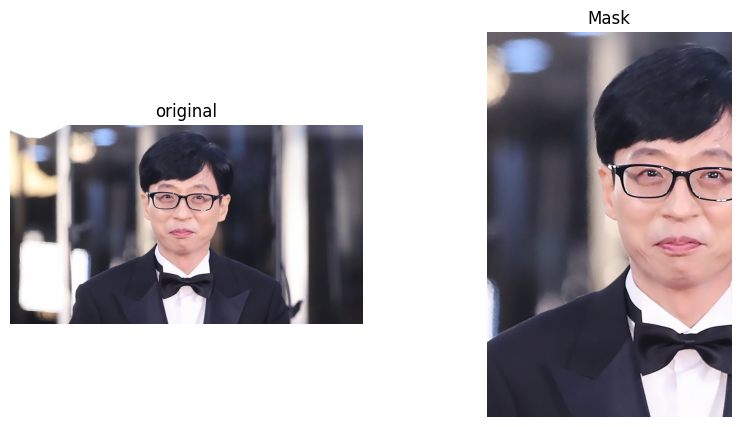

1/1 [==============================] - 0s 13ms/step
./test/images/yu1.jpg 끝냄
[{'left': 0, 'top': 0, 'right': 798, 'bottom': 700}]


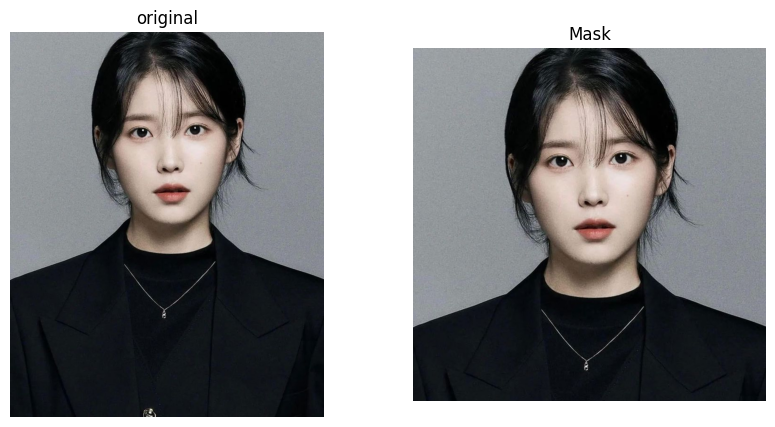

1/1 [==============================] - 0s 14ms/step
./test/images/IU.jpg 끝냄


In [208]:

hog_face_detector = dlib.get_frontal_face_detector()

print(glob('./test/images/*'))
for path_image in glob('./test/images/*'):
    if path_image.endswith('.png'):
        new_name = path_image[:-4]+'.jpg'
        os.rename(path_image, new_name)
        path_image = new_name
    image = cv2.imread(path_image)
    


    heads = getHead(hog_face_detector, image)
    
    

    for head in heads:
        img = image[head["top"]:head["bottom"], head["left"]:head["right"]]
        
        # Matplotlib를 사용하여 이미지 출력
        plt.figure(figsize=(10, 5))

        # 첫 번째 이미지 출력
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('original')
        plt.axis('off')

        # 두 번째 이미지 출력
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Mask')
        plt.axis('off')

        plt.show()

        mask = predict(img)

        dst = transfer(img, mask)
        
        # plt.imshow(dst)
        # cv2.imwrite(path_image.replace('images', 'outs'), dst)
        
        print(path_image, '끝냄')

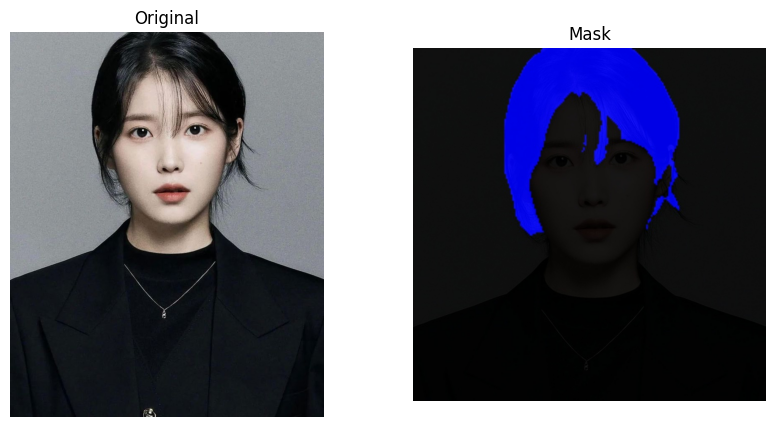

In [209]:
# 이미지 파일 읽기
image_A = cv2.imread('./test/images/IU.jpg')
image_B = cv2.imread('./test/outs/IU.jpg')

# Matplotlib를 사용하여 이미지 출력
plt.figure(figsize=(10, 5))

# 첫 번째 이미지 출력
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_A, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

# 두 번째 이미지 출력
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_B, cv2.COLOR_BGR2RGB))
plt.title('Mask')
plt.axis('off')

plt.show()

In [255]:
image = cv2.imread('./test/images/yu1.jpg', cv2.COLOR_BGR2RGB)

face_casecade = cv2.CascadeClassifier('./save_model/haarcascade_frontalface_default.xml')
faces = face_casecade.detectMultiScale(img, 1.1, 5)

for (left, top, right, bottom) in faces:
    
    # 영역 키우기
    size = 200
    bottom = min(top + bottom + size, img.shape[0])
    right = min(left + right + size, img.shape[1])
    top = max(top - size, 0)
    left = max(left - size, 0)
    
    img = image[top:bottom, left:right]
    
    # plt.imshow(img)
    
    mask = predict(img)
    
    dst = transfer(img, mask)
    
    print(dst)
    # plt.imshow(dst)
    # Image.fromarray(dst).show()
    
    # 이진화된 마스크를 기반으로 마스크 부분만 추출
    # masked_region = cv2.bitwise_and(img, img, mask=mask)
    
    # dst = transfer(img, mask)
    
    # plt.imshow(dst)
    
    # img - mask_n